In [1]:
# All imports/seeds
import train_reconstruction_embedding
import train_classification_model
import train_reconstruction_embedding_new

import logging as log
import argparse
import torch
import matplotlib
import torch.nn.functional as F
from torchmetrics.functional import accuracy, f1_score as f1
import lightning.pytorch as pl
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image
from dataloader.asimow_dataloader import DataSplitId, ASIMoWDataModule, load_npy_data, ASIMoWDataLoader
from utils import get_latent_dataloader, print_training_input_shape
from model.mlp import MLP
from dataloader.utils import get_val_test_ids
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
import os
import vector_quantize_pytorch

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
# %matplotlib inline

In [2]:
data_dict = get_val_test_ids()
val_ids = data_dict["val_ids"]
test_ids = data_dict["test_ids"]
val_ids = [DataSplitId(experiment=item[0], welding_run=item[1])
            for item in val_ids]
test_ids = [DataSplitId(experiment=item[0], welding_run=item[1])
            for item in test_ids]
data_module = ASIMoWDataModule(task="classification", batch_size=128, n_cycles=1, val_data_ids=val_ids, test_data_ids=test_ids)

data_module.setup('fit')

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

train_data = train_loader.dataset.data
val_data = val_loader.dataset.data
test_data = test_loader.dataset.data

train_labels = train_loader.dataset.labels
val_labels = val_loader.dataset.labels
test_labels = test_loader.dataset.labels

# load embeddings from file
complete_q_embeddings = np.load("created_files/q_emb_v1.npy")
complete_q_indices = np.load("created_files/train_loader_q_indices.npy")
# complete_q_embeddings_patch = np.load("created_files/patch_q_emb_v2.npy")
# complete_q_indices_patch = np.load("created_files/patch_q_ind_v2.npy")
# complete_q_embeddings_yannik_patch = np.load("created_files/yannik_patch_train_loader_q_embeddings.npy")
# complete_q_indices_yannik_patch = np.load("created_files/yannik_patch_train_loader_q_indices.npy")

# load my_trained_mlp from ckpt
my_trained_mlp = MLP(input_size=26, output_size=2, in_dim=32, hidden_sizes=512)
my_trained_mlp.load_state_dict(torch.load("my_trained_mlp.ckpt"))
my_trained_mlp.eval()
my_trained_mlp_on_patch = MLP(input_size=16, output_size=2, in_dim=64, hidden_sizes=512)
my_trained_mlp_on_patch.load_state_dict(torch.load("my_trained_mlp_on_patch.ckpt"))
my_trained_mlp_on_patch.eval()
my_trained_mlp_on_yannik_patch = MLP(input_size=16, output_size=2, in_dim=32, hidden_sizes=512)
my_trained_mlp_on_yannik_patch.load_state_dict(torch.load("my_trained_mlp_on_yannik_patch.ckpt"))
my_trained_mlp_on_yannik_patch.eval()

# load all_saliency_maps and all_saliency_maps_bad from npy
# all_saliency_maps = np.load("created_files/all_saliency_maps.npy")
# all_saliency_maps_bad = np.load("created_files/all_saliency_maps_bad.npy")
# all_saliency_maps_embed_mean = np.load("created_files/all_saliency_maps_embed_mean.npy")
# all_saliency_maps_embed_mean_bad = np.load("created_files/all_saliency_maps_embed_mean_bad.npy")
# all_saliency_maps_dim_mean = np.load("created_files/all_saliency_maps_dim_mean.npy")
# all_saliency_maps_dim_mean_bad = np.load("created_files/all_saliency_maps_dim_mean_bad.npy")

complete_q_tensor = torch.round(torch.tensor(complete_q_embeddings, dtype=torch.float32), decimals=3)
# complete_q_tensor_patch = torch.round(torch.tensor(complete_q_embeddings_patch, dtype=torch.float32), decimals=3)
# complete_q_tensor_yannik_patch = torch.round(torch.tensor(complete_q_embeddings_yannik_patch, dtype=torch.float32), decimals=3)


# Learning

VQ-VAE trainiert die Modelle in die model_checkpoints folder. In VQ-VAE wird das entsprechende Modell abgelegt, in VQ-VAE-MLP das Klassifizierungsmodell dazu.

Die Metriken werden einmal in logs/vq-vae-transformer/version_0 abgelegt

In [16]:
# Training of Reconstruction and Embedding

rec_parser = argparse.ArgumentParser(description='Train VQ-VAE')
rec_parser.add_argument('--epochs', type=int, help='Number of epochs to train', default=50)
rec_parser.add_argument('--dataset', type=str, help='Dataset', default="asimow")
rec_parser.add_argument('--num-embeddings', type=int, help='Number of embeddings', default=256)
rec_parser.add_argument('--embedding-dim', type=int, help='Dimension of one embedding', default=32)
rec_parser.add_argument('--hidden-dim', type=int, help='Hidden dimension', default=32)
rec_parser.add_argument('--learning-rate', type=float, help='Learning rate', default=0.001)
rec_parser.add_argument('--clipping-value', type=float, help='Gradient Clipping', default=0.7)
rec_parser.add_argument('--batch-size', type=int, help='Batch size', default=512)
rec_parser.add_argument('--n-resblocks', type=int, help='Number of Residual Blocks', default=1)
rec_parser.add_argument('--patch-size', type=int, help='Patch size of the VQ-VAE Encoder', default=25)
rec_parser.add_argument('--dropout-p', type=float, help='Dropout probability', default=0.1)
rec_parser.add_argument('--model-name', type=str, help='Model name', default="VQ-VAE")
rec_parser.add_argument('--decoder-type', type=str, help='VQ-VAE Decoder Type', default="Conv")

rec_parser.add_argument('--use-wandb', help='Use Weights and Bias (https://wandb.ai/) for Logging', action=argparse.BooleanOptionalAction)
rec_parser.add_argument('--wandb-entity', type=str, help='Weights and Bias entity')
rec_parser.add_argument('--wandb-project', type=str, help='Weights and Bias project')

rec_patch_parser = argparse.ArgumentParser(description='Train VQ-VAE with Patch')
rec_patch_parser.add_argument('--epochs', type=int, help='Number of epochs to train', default=30)
rec_patch_parser.add_argument('--dataset', type=str, help='Dataset', default="asimow")
rec_patch_parser.add_argument('--num-embeddings', type=int, help='Number of embeddings', default=256)
rec_patch_parser.add_argument('--embedding-dim', type=int, help='Dimension of one embedding', default=32)
rec_patch_parser.add_argument('--hidden-dim', type=int, help='Hidden dimension', default=32)
rec_patch_parser.add_argument('--learning-rate', type=float, help='Learning rate', default=0.001)
rec_patch_parser.add_argument('--clipping-value', type=float, help='Gradient Clipping', default=0.7)
rec_patch_parser.add_argument('--batch-size', type=int, help='Batch size', default=512)
rec_patch_parser.add_argument('--n-resblocks', type=int, help='Number of Residual Blocks', default=1)
rec_patch_parser.add_argument('--patch-size', type=int, help='Patch size of the VQ-VAE Encoder', default=25)
rec_patch_parser.add_argument('--dropout-p', type=float, help='Dropout probability', default=0.1)
rec_patch_parser.add_argument('--model-name', type=str, help='Model name', default="VQ-VAE-Patch")
rec_patch_parser.add_argument('--decoder-type', type=str, help='VQ-VAE Decoder Type', default="Conv")

rec_patch_parser.add_argument('--use-wandb', help='Use Weights and Bias (https://wandb.ai/) for Logging', action=argparse.BooleanOptionalAction)
rec_patch_parser.add_argument('--wandb-entity', type=str, help='Weights and Bias entity')
rec_patch_parser.add_argument('--wandb-project', type=str, help='Weights and Bias project')

args, unkown = rec_parser.parse_known_args()
print(args)
# What is the function of these lines of code?
matplotlib.use('agg')
FORMAT = '%(asctime)s - %(levelname)s - %(message)s'
log.basicConfig(level=log.INFO, format=FORMAT)
torch.set_float32_matmul_precision('medium')

# train_reconstruction_embedding.main(args)

Namespace(epochs=50, dataset='asimow', num_embeddings=256, embedding_dim=32, hidden_dim=32, learning_rate=0.001, clipping_value=0.7, batch_size=512, n_resblocks=1, patch_size=25, dropout_p=0.1, model_name='VQ-VAE', decoder_type='Conv', use_wandb=None, wandb_entity=None, wandb_project=None)


In [3]:
from train_reconstruction_embedding import classify_latent_space
from model.vq_vae import VectorQuantizedVAE
model_path = f"./model_checkpoints/VQ-VAE/VQ-VAE-asimow-best.ckpt"
model_dict = torch.load(model_path, map_location=torch.device('cuda'))
hparams = model_dict['hyper_parameters']
model = VectorQuantizedVAE(**hparams)
model.load_state_dict(model_dict['state_dict'])
logger = CSVLogger("logs", name="latent_space_classification")

classify_latent_space(latent_model=model, logger=logger, val_ids=val_ids, test_ids=test_ids, n_cycles=1, model_name="VQ-VAE", 
                            dataset="asimow", classification_model="MLP", learning_rate=0.001, clipping_value=0.7)

146it [00:06, 20.93it/s]
22it [00:00, 29.87it/s]
21it [00:00, 48.14it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/antonin/miniforge3/envs/welding_new/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/antonin/workspace/VQ-VAE-Transformer-Arc-Welding/model_checkpoints/VQ-VAE-MLP exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleList | 174 K 
----------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


best score: 0.6681422317165068
------ Testing ------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.7314867377281189     │
│       test/acc_bad        │    0.8595792651176453     │
│       test/acc_good       │    0.5906016826629639     │
│       test/f1_score       │    0.6751238703727722     │
│    test/f1_score_mean     │    0.6751607656478882     │
│         test/loss         │     0.469178706407547     │
└───────────────────────────┴───────────────────────────┘

In [11]:
parser = argparse.ArgumentParser(description='Train VQ-VAE-Patch')
parser.add_argument('--epochs', type=int, help='Number of epochs to train', default=100)
parser.add_argument('--batch-size', type=int, help='Batch size', default=1024)
parser.add_argument('--num-embeddings', type=int, help='Number of embeddings', default=256)
parser.add_argument('--embedding-dim', type=int, help='Dimension of one embedding', default=32)
parser.add_argument('--hidden-dim', type=int, help='Hidden dimension', default=256)
parser.add_argument('--learning-rate', type=float, help='Learning rate', default=0.001)
parser.add_argument('--clipping-value', type=float, help='Gradient Clipping', default=0.7)
parser.add_argument('--n-resblocks', type=int, help='Number of Residual Blocks', default=8)
parser.add_argument('--patch-size', type=int, help='Patch size of the VQ-VAE Encoder', default=25)
parser.add_argument('--dropout-p', type=float, help='Dropout probability', default=0.1)
parser.add_argument('--batchnorm', type=int, help='Use the batch normalization layers', default=0)

parser.add_argument('--use-improved-vq', help='Use the improved VQ mechanism', action=argparse.BooleanOptionalAction)
parser.add_argument('--kmeans-iters', type=int, help='Number of K-Means iterations', default=10)
parser.add_argument('--threshold-ema-dead-code', type=int, help='Threshold for EMA dead code', default=2)

parser.add_argument('--model-name', type=str, help='Model name', default="VQ-VAE-Patch")

parser.add_argument('--use-wandb', help='Use Weights and Bias (https://wandb.ai/) for Logging', action=argparse.BooleanOptionalAction)
parser.add_argument('--use-mlflow', help='Use MLflow (https://mlflow.org/docs/latest/index.html) for Logging', action=argparse.BooleanOptionalAction)
parser.add_argument('--mlflow-url', type=str, help='URL of the MLflow server', default='http://mlflow.tmdt.uni-wuppertal.de/')


parser.add_argument('--logging-entity', type=str, help='Weights and Bias or MLflow entity')
parser.add_argument('--logging-project', type=str, help='Weights and Bias or MLflow project', default="asimow-vq-vae")

args, unkown = parser.parse_known_args()
# args.use_improved_vq=True
# args
print(args)
matplotlib.use('agg')

FORMAT = '%(asctime)s - %(levelname)s - %(message)s'
log.basicConfig(level=log.INFO, format=FORMAT)

torch.set_float32_matmul_precision('medium')
train_reconstruction_embedding_new.main(args)

Namespace(epochs=100, batch_size=1024, num_embeddings=256, embedding_dim=32, hidden_dim=256, learning_rate=0.001, clipping_value=0.7, n_resblocks=8, patch_size=25, dropout_p=0.1, batchnorm=0, use_improved_vq=None, kmeans_iters=10, threshold_ema_dead_code=2, model_name='VQ-VAE-Patch', use_wandb=None, use_mlflow=None, mlflow_url='http://mlflow.tmdt.uni-wuppertal.de/', logging_entity=None, logging_project='asimow-vq-vae')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/antonin/miniforge3/envs/welding_new/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/antonin/workspace/VQ-VAE-Transformer-Arc-Welding/model_checkpoints/VQ-VAE-Patch exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                  | Params
--------------------------------------------------------------
0 | patch_embed         | PatchEmbedding        | 6.7 K 
1 | encoder             | Sequential            | 3.2 M 
2 | vector_quantization | VectorQuantizer       | 8.2 K 
3 | decoder             | Sequential            | 3.2 M 
4 | reverse_patch_embed | PatchEmbeddingInverse | 329 K 
--------------------------------------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │   0.013759469613432884    │
│     test/recon_error      │   0.011055447161197662    │
└───────────────────────────┴───────────────────────────┘

In [7]:
# args.use_improved_vq=True
args

Namespace(epochs=100, batch_size=1024, num_embeddings=256, embedding_dim=16, hidden_dim=256, learning_rate=0.001, clipping_value=0.7, n_resblocks=8, patch_size=25, dropout_p=0.1, batchnorm=0, use_improved_vq=True, kmeans_iters=10, threshold_ema_dead_code=2, model_name='VQ-VAE-Patch', use_wandb=None, use_mlflow=None, mlflow_url='http://mlflow.tmdt.uni-wuppertal.de/', logging_entity=None, logging_project='asimow-vq-vae')

In [4]:
from model.vq_vae import VectorQuantizedVAE

def get_model(model_name: str, file_name: str):
    model_path = f"./model_checkpoints/{model_name}/{file_name}"
    if os.path.exists(model_path):
        model_name = 'VQ VAE'
        print("model exists, no download needed")
    else:
        print("model missing")
        return None, None
    #model_name, model_path = get_pretrained_vqvae_models("vq_vae_model")
    vq_vae_dict = torch.load(model_path, map_location=torch.device('cpu'))
    print(vq_vae_dict['hyper_parameters'])
    vq_vae_dict['hyper_parameters'].pop('logger')
    model = VectorQuantizedVAE(**vq_vae_dict['hyper_parameters'])
    model.load_state_dict(vq_vae_dict['state_dict'])

    return model, vq_vae_dict['hyper_parameters']

model, hparams = get_model("VQ-VAE", "VQ-VAE-asimow-best.ckpt")
# print(hparams)
model.eval()
codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)


model exists, no download needed
{'logger': <lightning.pytorch.loggers.csv_logs.CSVLogger object at 0x7fad71d918a0>, 'hidden_dim': 32, 'input_dim': 2, 'num_embeddings': 256, 'embedding_dim': 32, 'n_resblocks': 1, 'learning_rate': 0.001, 'seq_len': 200, 'dropout_p': 0.1, 'decoder_type': 'Conv'}


In [23]:
from model.vq_vae_patch_embedd import VQVAEPatch

def get_model_patch(model_name: str, file_name: str):
    model_path = f"./model_checkpoints/{model_name}/{file_name}"
    if os.path.exists(model_path):
        model_name = 'VQ VAE'
        print("model exists, no download needed")
    else:
        print("model missing")
        return None, None
    #model_name, model_path = get_pretrained_vqvae_models("vq_vae_model")
    vq_vae_dict = torch.load(model_path, map_location=torch.device('cpu'))
    print(vq_vae_dict['hyper_parameters'])
    # vq_vae_dict['hyper_parameters'].pop('wandb_logger')
    model = VQVAEPatch(**vq_vae_dict['hyper_parameters'])
    model.load_state_dict(vq_vae_dict['state_dict'])

    return model, vq_vae_dict['hyper_parameters']

mein_model, meine_hparams = get_model_patch("VQ-VAE-Patch", "VQ-VAE-Patch-best-v5.ckpt")
y_model, y_hparams = get_model_patch("VQ-VAE-Patch", "vq_vae_patch_best.ckpt")

# print(hparams)
mein_model.eval()
if meine_hparams["use_improved_vq"]:
    mein_codebook = torch.round(mein_model.vector_quantization.vq.codebooks[0], decimals=3)
else:
    mein_codebook = torch.round(mein_model.vector_quantization.embedding.weight.data, decimals=3)
y_model.eval()
y_codebook = torch.round(y_model.vector_quantization.embedding.weight.data, decimals=3)

model exists, no download needed
{'hidden_dim': 256, 'input_dim': 2, 'num_embeddings': 256, 'embedding_dim': 32, 'n_resblocks': 8, 'learning_rate': 0.001, 'seq_len': 200, 'dropout_p': 0.1, 'patch_size': 25, 'batch_norm': False, 'beta': 0.25, 'use_improved_vq': None, 'kmeans_iters': 10, 'threshold_ema_dead_code': 2}
model exists, no download needed
{'hidden_dim': 256, 'input_dim': 2, 'num_embeddings': 256, 'embedding_dim': 32, 'n_resblocks': 8, 'learning_rate': 0.001, 'seq_len': 200, 'dropout_p': 0.1, 'patch_size': 25, 'batch_norm': False, 'beta': 0.25}


In [22]:
# get hyperparameters of the model
mein_model

VQVAEPatch(
  (patch_embed): PatchEmbedding(
    (proj): Conv1d(1, 256, kernel_size=(25,), stride=(25,))
  )
  (encoder): Sequential(
    (0): CNNBlock(
      (shared_conv): Sequential(
        (0): ResBlock(
          (block): Sequential(
            (0): GELU(approximate='none')
            (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (2): Identity()
            (3): GELU(approximate='none')
            (4): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (5): Identity()
            (6): Dropout(p=0.1, inplace=False)
          )
        )
        (1): ResBlock(
          (block): Sequential(
            (0): GELU(approximate='none')
            (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (2): Identity()
            (3): GELU(approximate='none')
            (4): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (5): Identity()
            (6): Dropout(p=0.1, inplace=F

In [116]:
def send_through_patch_model(model, input_data, reconstruct=False):
    with torch.no_grad():
        x = model.patch_embed(input_data)
        z_e = model.encoder(x)
        embedding_loss, z_q, perplexity, _, q_indices = model.vector_quantization(z_e)
        x_hat = None
        recon_error = None
        loss = None
        if reconstruct:
            x_hat = model.decoder(z_q.permute(0, 2, 1))
            x_hat = model.reverse_patch_embed(x_hat)
            recon_error = F.mse_loss(x_hat, input_data)
            loss = recon_error + embedding_loss
    return embedding_loss, x_hat, perplexity, z_q, q_indices, recon_error, loss

data = torch.from_numpy(train_data[3]).float()
embedding_loss, x_hat_patch, perplexity, q_data, q_indices, recon_error, loss = send_through_patch_model(mein_model, data.unsqueeze_(0), reconstruct=True)
# recon_error, loss, embedding_loss, perplexity

In [5]:
def send_through_model(model, input_data, reconstruct=True):
    with torch.no_grad():
        permuted_original = input_data.permute(0, 2, 1)
        z_e = model.encoder(permuted_original)
        encoded_data = z_e.permute(0,2,1)
        embedding_loss, quantized_data, perplexity, _, q_indices = model.vector_quantization(encoded_data)
        z_q = quantized_data.permute(0,2,1)
        if model.decoder_type == "Linear":
            z_q = z_q.reshape(z_q.shape[0], z_q.shape[1] * z_q.shape[2])
        x_hat = None
        recon_error = None
        loss = None
        if reconstruct:
            x_hat = model.decoder(z_q)
            if model.decoder_type == "Conv":
                x_hat = x_hat.permute(0, 2, 1)
            recon_error = F.mse_loss(x_hat, input_data)
            loss = recon_error + embedding_loss

    return embedding_loss, x_hat, perplexity, quantized_data, q_indices, recon_error, loss

data = torch.from_numpy(train_data[2]).float()
print(data)
embedding_loss, x_hat, perplexity, quantized_data, q_indices, recon_error, loss = send_through_model(model, data.unsqueeze(0))
# recon_error, loss, embedding_loss, perplexity

tensor([[-0.6811, -0.6543],
        [-0.5575, -0.6072],
        [-0.3594, -0.4173],
        [-0.2138, -0.1871],
        [-0.0774,  0.0435],
        [ 0.0583,  0.2658],
        [ 0.1857,  0.4783],
        [ 0.3305,  0.6758],
        [ 0.4845,  0.8589],
        [ 0.6347,  1.0364],
        [ 0.7954,  1.2094],
        [ 0.9454,  1.3714],
        [ 1.1087,  1.5304],
        [ 1.2349,  1.6770],
        [ 1.3852,  1.8138],
        [ 1.4979,  1.9426],
        [ 1.5892,  2.0602],
        [ 1.6721,  2.1627],
        [ 1.6595,  2.2136],
        [ 1.6686,  2.2275],
        [ 1.6751,  2.2218],
        [ 1.6973,  2.2237],
        [ 1.7138,  2.2290],
        [ 1.6979,  2.2305],
        [ 1.7150,  2.2215],
        [ 1.7208,  2.2185],
        [ 1.7712,  2.2185],
        [ 1.7758,  2.2309],
        [ 1.7468,  2.2335],
        [ 1.7521,  2.2256],
        [ 1.7719,  2.2200],
        [ 1.7882,  2.2188],
        [ 1.8304,  2.2301],
        [ 1.8189,  2.2294],
        [ 1.8082,  2.2264],
        [ 1.8294,  2

In [6]:
torch.cuda.is_available()

False

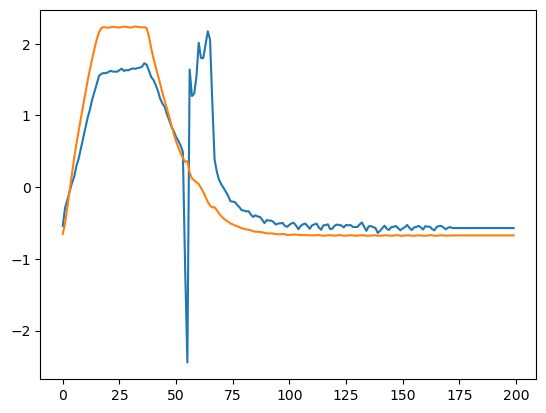

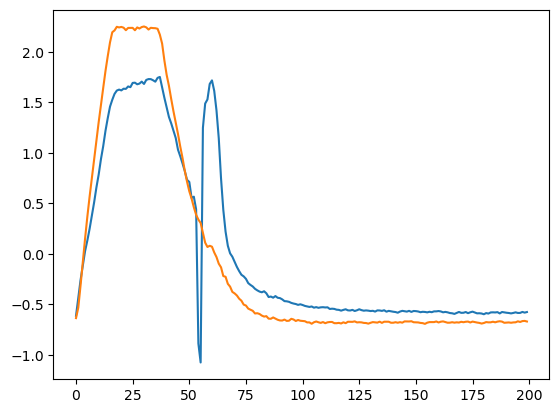

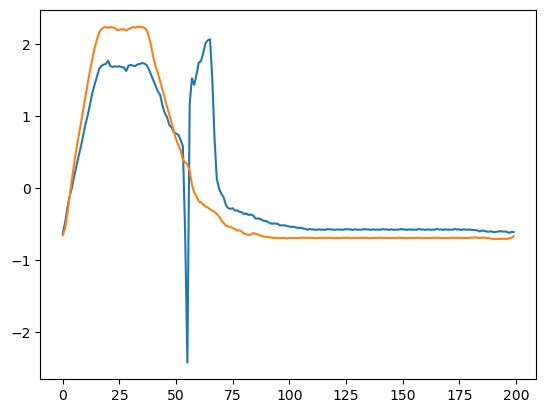

In [118]:
plt.plot(data.detach().numpy())
plt.show()
plt.plot(x_hat_patch[0].detach().numpy())
plt.show()
plt.plot(x_hat[0].detach().numpy())

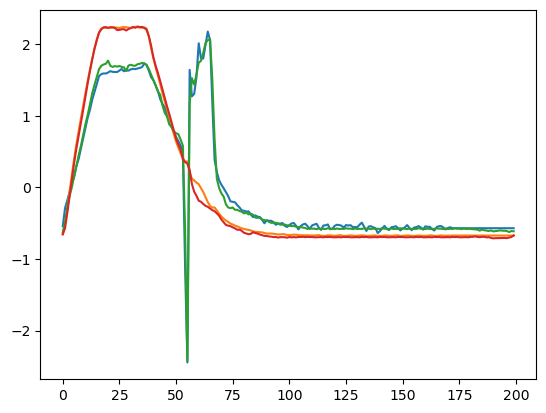

In [76]:
plt.plot(data)
plt.plot(x_hat[0])

In [96]:
q_data[0][0]

tensor([-0.0188,  0.4558,  0.0895, -0.0624,  0.1460, -0.5115,  0.9256,  1.0684,
         0.1420,  0.0197,  0.3297, -0.2570,  0.0214,  0.4755, -0.5310, -0.2346])

In [97]:
mein_codebook[q_indices[0][0]]

tensor([[-0.0188,  0.4558,  0.0895, -0.0624,  0.1460, -0.5115,  0.9256,  1.0684,
          0.1420,  0.0197,  0.3297, -0.2570,  0.0214,  0.4755, -0.5310, -0.2346]])

In [119]:
def get_q_or_e_embeddings(loader, model, amount_of_ts=None):
    if amount_of_ts is None:
        amount_of_ts = len(loader.dataset)
        print(amount_of_ts)
    my_data_list = np.ones((amount_of_ts,model.enc_out_len,model.embedding_dim), float)
    my_indices_list = np.ones((amount_of_ts,model.enc_out_len), int)
    
    for i in range(amount_of_ts):
        embedding_loss, x_hat_patch, perplexity, q_data, q_indices, recon_error, loss = send_through_patch_model(model, loader.dataset[i][0].unsqueeze(0), reconstruct=False)

        # _, _, _, q_data, q_data_indices = send_through_patch_model(x=loader.dataset[i][0], model=model, reconstruct=False)
        # _, _, _, _, _, q_data, q_data_indices, _, _ = send_through_model(loader.dataset[i][0], model, reconstruct=False)
        # _, _, e_data, q_data, q_data_indices, _, _ = send_through_model(loader.dataset[i][0], model, reconstruct=False)
        my_data_list[i] = q_data.detach().numpy()
        my_indices_list[i] = q_indices.detach().numpy().reshape(-1)
        if i % 1000 == 0:
            print(f"i: {i}", end="\r")
    return my_data_list, my_indices_list

In [124]:
complete_q_embeddings, complete_q_indices = get_q_or_e_embeddings(train_loader, mein_model, amount_of_ts=None)
np.save("created_files/patch_q_ind_v5.npy", complete_q_indices)
np.save("created_files/patch_q_emb_v5.npy", complete_q_embeddings)

74732


In [123]:
complete_q_embeddings.shape

(2, 16, 32)

In [82]:
complete_q_embeddings, complete_q_indices = get_q_or_e_embeddings(train_loader, y_model, amount_of_ts=None)
np.save("created_files/yannik_patch_train_loader_q_indices.npy", complete_q_indices)
np.save("created_files/yannik_patch_train_loader_q_embeddings.npy", complete_q_embeddings)

74732


In [9]:
# load embeddings from file
complete_q_embeddings = np.load("created_files/patch_q_emb_v5.npy")
complete_q_indices = np.load("created_files/patch_q_ind_v5.npy")

complete_q_tensor = torch.round(torch.tensor(complete_q_embeddings, dtype=torch.float32), decimals=3)

In [13]:
complete_q_embeddings.shape

(74732, 16, 32)

In [12]:
def generate_saliency_map(model, input_data, target_class):
    input_data.requires_grad = True
    print(input_data.unsqueeze(0).shape)
    logits = model(input_data.unsqueeze(0))
    loss = F.cross_entropy(logits, torch.tensor([target_class]))
    loss.backward()
    saliency_map = input_data.grad.squeeze().abs()
    return saliency_map

In [10]:

logger = CSVLogger("logs", name="my_exp_name")

# # Instantiate the MLP
mlp = MLP(input_size=26, output_size=2, in_dim=32, hidden_sizes=512, n_hidden_layers=16)

def train_mlp_on_embeddings(complete_q_embeddings, model, label_list):
    # Prepare data and labels as tensors
    data = complete_q_embeddings
    print(data.shape)
    labels = label_list
    print(labels.shape)
    data_tensor = torch.tensor(data, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # Split the data into train and validation sets
    train_data = data_tensor[:int(0.8 * len(data_tensor))]
    train_labels = labels_tensor[:int(0.8 * len(labels_tensor))]
    val_data = data_tensor[int(0.8 * len(data_tensor)):]
    val_labels = labels_tensor[int(0.8 * len(labels_tensor)):]

    # Create a dataset
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    complete_dataset = TensorDataset(data_tensor, labels_tensor)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64)
    val_loader = DataLoader(val_dataset, batch_size=64)

    # # Define Callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints", monitor=f"train/f1_score", mode="max", filename=f"best_model")
    early_stop_callback = EarlyStopping(
        monitor=f"train/f1_score", min_delta=0.0001, patience=10, verbose=False, mode="max")

    # # Define a PyTorch Lightning trainer
    trainer = pl.Trainer(max_epochs=80, logger=logger, callbacks=[checkpoint_callback, early_stop_callback])  # Adjust max_epochs as needed

    # # Train the model
    trainer.fit(model, train_loader)
    
    # # Test the model
    trainer.test(model, val_loader)

    return model

my_trained_mlp_28_03_v2 = train_mlp_on_embeddings(complete_q_embeddings, mlp, train_labels)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/antonin/miniforge3/envs/welding_new/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/antonin/miniforge3/envs/welding_new/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/antonin/workspace/VQ-VAE-Transformer-Arc-Welding/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleList | 4.6 M 
--------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.590    Total estimated model params size (MB)


(74732, 26, 32)
(74732,)


/home/antonin/miniforge3/envs/welding_new/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/antonin/miniforge3/envs/welding_new/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.7550010085105896     │
│       test/acc_bad        │    0.7943668365478516     │
│       test/acc_good       │    0.7106924057006836     │
│       test/f1_score       │    0.7275729775428772     │
│    test/f1_score_mean     │    0.7275723814964294     │
│         test/loss         │    0.6833776235580444     │
└───────────────────────────┴───────────────────────────┘

In [11]:
# save my_trained_mlp as ckpt
torch.save(my_trained_mlp_28_03_v2.state_dict(), "MLPs/my_trained_mlp_28_03_v2.ckpt")

In [166]:
# save my_trained_mlp as ckpt
# torch.save(my_trained_mlp.state_dict(), "my_trained_mlp.ckpt")

# Load my_trained_mlp from ckpt
my_trained_mlp = MLP(input_size=16, output_size=2, in_dim=16, hidden_sizes=512)
my_trained_mlp.load_state_dict(torch.load("my_trained_mlp_on_patch_v1.ckpt"))
my_trained_mlp.eval()

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (1

In [165]:
data = complete_q_embeddings
print(data.shape)
labels = train_labels
print(labels.shape)
data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Split the data into train and validation sets
train_data = data_tensor[:int(0.8 * len(data_tensor))]
train_labels_intern = labels_tensor[:int(0.8 * len(labels_tensor))]
test_data = data_tensor[int(0.8 * len(data_tensor)):]
test_labels = labels_tensor[int(0.8 * len(labels_tensor)):]

# Create a dataset
train_dataset = TensorDataset(train_data, train_labels_intern)
test_dataset = TensorDataset(test_data, test_labels)
complete_dataset = TensorDataset(data_tensor, labels_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# # Define Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints", monitor=f"train/f1_score", mode="max", filename=f"best_model")
early_stop_callback = EarlyStopping(
    monitor=f"train/f1_score", min_delta=0.0001, patience=10, verbose=False, mode="max")

# # Define a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=80, logger=logger, callbacks=[checkpoint_callback, early_stop_callback])  # Adjust max_epochs as needed

# # Train the model
trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/antonin/mambaforge/envs/welding_new/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/home/antonin/mambaforge/envs/welding_new/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/antonin/welding-data/VQ-VAE-Transformer-Arc-Welding/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name                | Type            | Params
--------------------------------------------------------
0 | encoder             | Sequential      | 13.2 K
1 | vector_quantization | VectorQuantizer | 8.2 K 
2 | decoder             | Sequential      | 13.1 K
-------------

(74732, 26, 32)
(74732,)


/home/antonin/mambaforge/envs/welding_new/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

AttributeError: 'list' object has no attribute 'permute'

In [31]:
def generate_saliency_map(model, input_data, target_class):
    if type(input_data) == np.ndarray:
        input_data = torch.tensor(input_data, dtype=torch.float32)
    input_data.requires_grad = True
    logits = model(input_data.unsqueeze(0))
    loss = F.cross_entropy(logits, torch.tensor([target_class]))
    loss.backward()
    saliency_map = input_data.grad.squeeze().abs()
    sm_embed_mean = saliency_map.mean(dim=1, keepdim=True)
    sm_dim_mean = saliency_map.mean(dim=0, keepdim=True)
    return saliency_map, sm_embed_mean, sm_dim_mean

my_saliency_map, my_saliency_map_embed_mean, my_saliency_map_dim_mean = generate_saliency_map(my_trained_mlp, complete_q_embeddings[0], 0)

In [55]:
# all_saliency_maps = torch.empty((len(complete_q_embeddings), 26, 32))
# all_saliency_maps_embed_mean = torch.empty((len(complete_q_embeddings), 26, 1))
# all_saliency_maps_dim_mean = torch.empty((len(complete_q_embeddings), 1, 32))
# all_saliency_maps_bad = torch.empty((len(complete_q_embeddings), 26, 32))
# all_saliency_maps_embed_mean_bad = torch.empty((len(complete_q_embeddings), 26, 1))
# all_saliency_maps_dim_mean_bad = torch.empty((len(complete_q_embeddings), 1, 32))


# q_embeddings_tensor = torch.tensor(complete_q_embeddings, dtype=torch.float32)
# for i, data in enumerate(q_embeddings_tensor):
#     all_saliency_maps[i], all_saliency_maps_embed_mean[i], all_saliency_maps_dim_mean[i] = generate_saliency_map(my_trained_mlp, data, 1)
#     all_saliency_maps_bad[i], all_saliency_maps_embed_mean_bad[i], all_saliency_maps_dim_mean_bad[i] = generate_saliency_map(my_trained_mlp, data, 0)
#     if i % 1000 == 0:
#         print(f"i: {i}", end="\r")
# # save all_saliency_maps and all_saliency_maps_bad as npy in existing folder called created_files
# np.save("created_files/all_saliency_maps.npy", all_saliency_maps)
# np.save("created_files/all_saliency_maps_bad.npy", all_saliency_maps_bad)
# np.save("created_files/all_saliency_maps_embed_mean.npy", all_saliency_maps_embed_mean)
# np.save("created_files/all_saliency_maps_embed_mean_bad.npy", all_saliency_maps_embed_mean_bad)
# np.save("created_files/all_saliency_maps_dim_mean.npy", all_saliency_maps_dim_mean)
# np.save("created_files/all_saliency_maps_dim_mean_bad.npy", all_saliency_maps_dim_mean_bad)


In [32]:
def plot_saliency_map(all_saliency_maps, model, index=0):
    sm = torch.tensor(all_saliency_maps[index])
    sm_summed_or_mean = sm.mean(dim=1, keepdim=True)
    sm_dim_summed_or_mean = sm.mean(dim=0, keepdim=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(sm, cmap='Wistia')
    plt.title(f'Saliency Map mit  {model.enc_out_len} x {model.embedding_dim}')

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.imshow(sm_summed_or_mean, cmap='Wistia')
    plt.title(f'Mean über {model.enc_out_len} Embeddings')

    plt.subplot(1, 3, 3)
    plt.yticks([])
    plt.imshow(sm_dim_summed_or_mean, cmap='Wistia')
    plt.title(f'Mean über {model.embedding_dim} Dimensionen')
    
    plt.show()

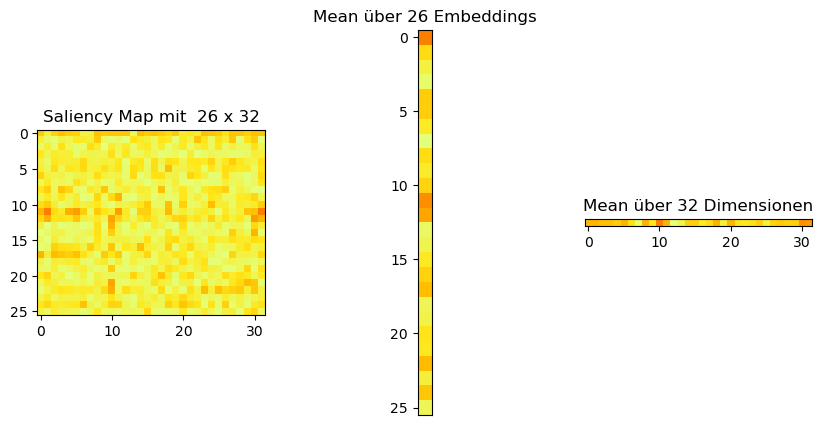

In [36]:
plot_saliency_map(all_saliency_maps, index=0, model=model)

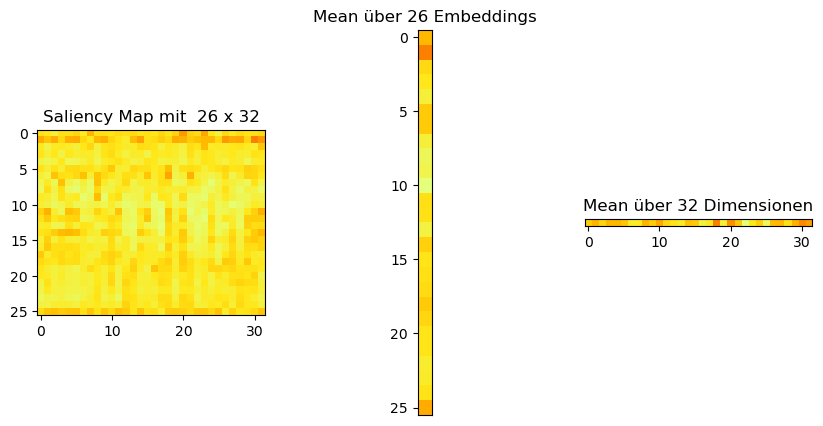

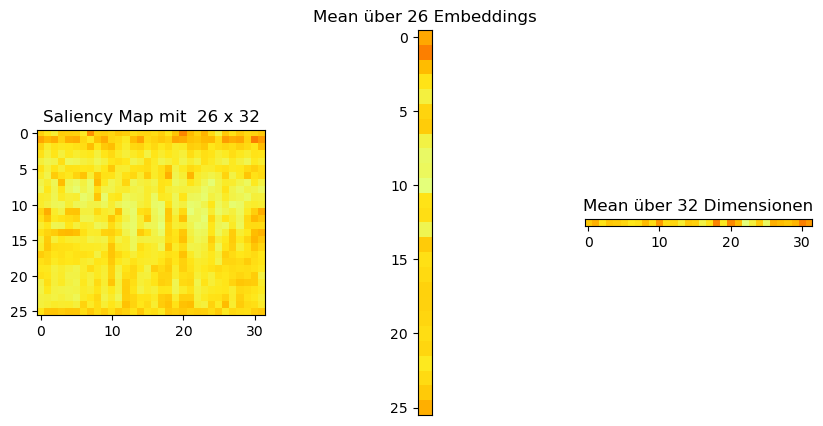

In [37]:
def create_mean_saliency_map(all_saliency_maps):
    mean_saliency_map = all_saliency_maps.mean(axis=0)
    return mean_saliency_map

mean_sm = create_mean_saliency_map(all_saliency_maps)
mean_sm_bad = create_mean_saliency_map(all_saliency_maps_bad)
plot_saliency_map([create_mean_saliency_map(all_saliency_maps)], index=0, model=model)
plot_saliency_map([create_mean_saliency_map(all_saliency_maps_bad)], index=0, model=model)

In [39]:
def extract_means(saliency_map):
    sm = torch.tensor(saliency_map)
    embed_mean = sm.mean(dim=1, keepdim=True)
    embed_mean = embed_mean.reshape(embed_mean.shape[0])
    dim_mean = sm.mean(dim=0, keepdim=True)
    dim_mean = dim_mean.reshape(dim_mean.shape[1])
    return embed_mean, dim_mean
    
embedding_means, dim_means = extract_means(mean_sm)
embedding_means_bad, dim_means_bad = extract_means(mean_sm_bad)
print(embedding_means.shape)
print(dim_means.shape)
top_k = 3

print(f"Indices of most relevant embed positions for GOOD: {torch.topk(embedding_means, k=top_k)[1]}, Saliency Values: {torch.topk(embedding_means, k=top_k)[0]}")
print(f"Indices of most relevant embed positions for BAD: {torch.topk(embedding_means_bad, k=top_k)[1]}, Saliency Values: {torch.topk(embedding_means_bad, k=top_k)[0]}")

print(f"Indices of most relevant dim for GOOD: {torch.topk(dim_means, k=top_k)[1]}, Saliency Values: {torch.topk(dim_means, k=top_k)[0]}")
print(f"Indices of most relevant dim for BAD: {torch.topk(dim_means_bad, k=top_k)[1]}, Saliency Values: {torch.topk(dim_means_bad, k=top_k)[0]}")

torch.Size([26])
torch.Size([32])
Indices of most relevant embed positions for GOOD: tensor([ 1, 25,  0]), Saliency Values: tensor([0.9782, 0.7763, 0.7036])
Indices of most relevant embed positions for BAD: tensor([ 1,  0, 25]), Saliency Values: tensor([1.6669, 1.3594, 1.2954])
Indices of most relevant dim for GOOD: tensor([18, 30, 20]), Saliency Values: tensor([0.7067, 0.6896, 0.6783])
Indices of most relevant dim for BAD: tensor([30, 18, 20]), Saliency Values: tensor([1.2683, 1.2537, 1.2283])


In [41]:
print(complete_q_indices[0][11])
print(complete_q_tensor[0][11])
print(codebook[complete_q_indices[0][11]])

214
tensor([ 0.1670, -0.3430, -0.4940, -0.3580, -0.0660, -0.2410,  0.4420, -0.1290,
         0.9420, -0.0180,  0.2190, -0.4170,  0.6110, -0.6500, -0.0680,  0.4930,
         0.1750, -0.3300,  0.1860,  0.1780,  0.4380,  0.2380, -0.2640, -0.1680,
        -0.3710, -0.2300, -0.3990,  0.1470, -0.2000,  0.2110, -0.0840, -0.3430])
tensor([ 0.1670, -0.3430, -0.4940, -0.3580, -0.0660, -0.2410,  0.4420, -0.1290,
         0.9420, -0.0180,  0.2190, -0.4170,  0.6110, -0.6500, -0.0680,  0.4930,
         0.1750, -0.3300,  0.1860,  0.1780,  0.4380,  0.2380, -0.2640, -0.1680,
        -0.3710, -0.2300, -0.3990,  0.1470, -0.2000,  0.2110, -0.0840, -0.3430])


In [70]:

def return_dfs_for_embed_position(mean_tensor, id_list, position):
    id_list_p = id_list[:,position]
    saliency_p =np.array(mean_tensor)[:,position]
    df = pd.DataFrame({"embed_id": id_list_p, "saliency": saliency_p})
    saliency = df.groupby("embed_id").mean().sort_values(by="saliency", ascending=False)
    common = df.groupby("embed_id").count().sort_values(by="saliency", ascending=False)
    common = common.rename(columns={"saliency": "count"})
    most_common = common.join(saliency, on="embed_id").sort_values(by="count", ascending=False)
    highest_saliency = saliency.join(common, on="embed_id").sort_values(by="saliency", ascending=False)
    return most_common, highest_saliency

# print(all_saliency_maps_embed_mean.shape)
# print(complete_q_indices.shape)
# return_dfs_for_embed_position(torch.tensor(all_saliency_maps_embed_mean).reshape(74732, 26), complete_q_indices, 0)


def get_embed_ids_of_position(s_tensor, position, id_list, amount=5, plot=True):
    
    most_common_embed, highest_saliency_embed = return_dfs_for_embed_position(s_tensor, id_list, position)

    index_common_embeds = torch.tensor(most_common_embed.index[:amount])
    count_common_embeds = torch.tensor(most_common_embed["count"][:amount].values)
    saliency_common_embeds = torch.tensor(most_common_embed["saliency"][:amount].values)
    index_highest_saliency_embeds = torch.tensor(highest_saliency_embed.index[:amount])
    count_highest_saliency_embeds = torch.tensor(highest_saliency_embed["count"][:amount].values)
    saliency_highest_saliency_embeds = torch.tensor(highest_saliency_embed["saliency"][:amount].values)

    if plot:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

        # Plot the bar chart for Frequencies using the first y-axis (ax1)
        ax1.bar(index_common_embeds, count_common_embeds, width=2, color='b', label='Frequencies')
        ax1.set_xlabel('Values')
        ax1.set_ylabel('Frequencies', color='b')
        ax1.set_xlim(-1, 256)
        ax1.set_ylim(0, count_common_embeds.max() + 20)
        ax1.legend(loc='lower right')

        # Plot the bar chart for Average Values using the second y-axis (ax2)
        ax2.bar(index_common_embeds, saliency_common_embeds, width=2, color='y', alpha=0.7, label='Average Gradients')
        ax2.set_xlabel('Values')
        ax2.set_ylabel('Average Gradients', color='y')
        ax2.set_xlim(-1, 256)
        ax2.set_ylim(0, saliency_highest_saliency_embeds.max() + 0.5)
        ax2.legend(loc='lower right')

        ax3.bar(index_highest_saliency_embeds, count_highest_saliency_embeds, width=2, color='g', alpha=0.7, label='Highest Avg. Grad. Freq.')
        ax3.set_xlabel('Values')
        ax3.set_ylabel('Frequencies', color='g')
        ax3.set_xlim(-1, 256)
        ax3.set_ylim(0, count_common_embeds.max() + 20)
        ax3.legend(loc='lower right')

        ax4.bar(index_highest_saliency_embeds, saliency_highest_saliency_embeds, width=2, color='r', alpha=0.7, label='Highest Average Gradients')
        ax4.set_xlabel('Values')
        ax4.set_ylabel('Average Gradients', color='r')
        ax4.set_xlim(-1, 256)
        ax4.set_ylim(0, saliency_highest_saliency_embeds.max() + 0.5)
        ax4.legend(loc='lower right')

        # Adjust the layout to avoid overlap
        #plt.tight_layout()

        # Display the plot
        plt.suptitle(f'Top {amount} Most Common Embeddings and Their Frequencies and Average Gradients | Top {amount} Embeddings with highest average gradients and Their Frequencies and Average Gradients')
        plt.show()

    return index_common_embeds, count_common_embeds, saliency_common_embeds, index_highest_saliency_embeds, count_highest_saliency_embeds, saliency_highest_saliency_embeds

/tmp/ipykernel_3109641/2445649974.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_embed_means = torch.tensor(all_saliency_maps_embed_mean)


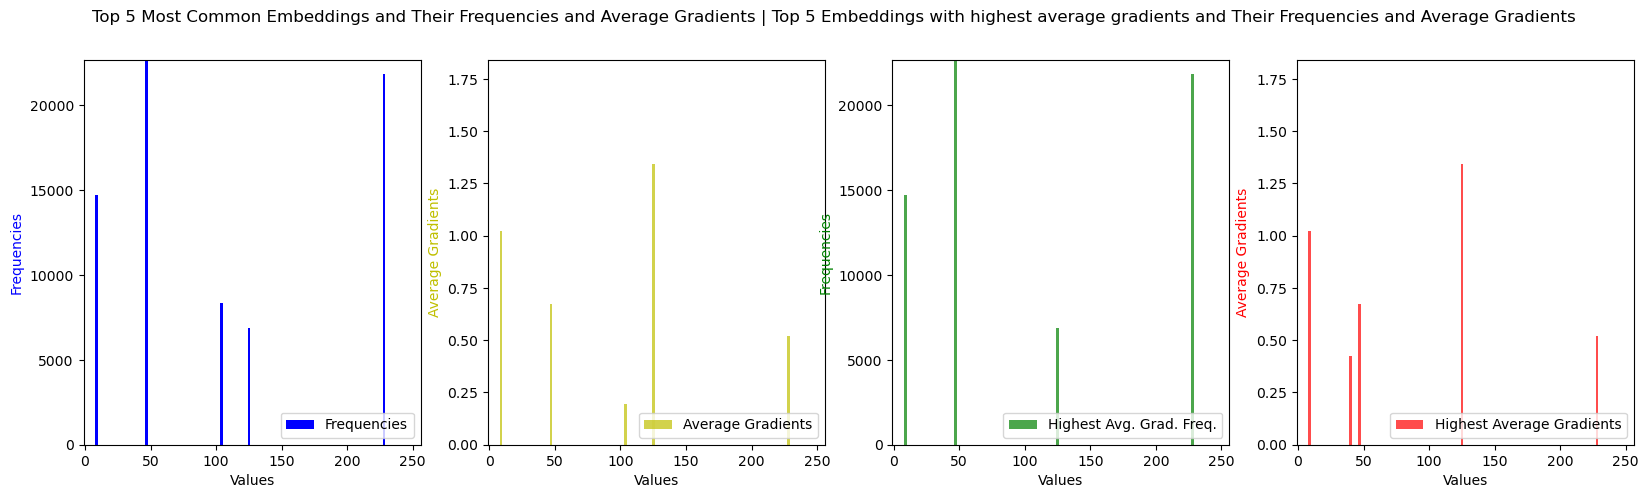

In [71]:
all_embed_means = torch.tensor(all_saliency_maps_embed_mean)
all_embed_means = all_embed_means.reshape(all_embed_means.shape[0], all_embed_means.shape[1])

ids_common, count_common, saliency_common, id_high_s, count_high_s, saliency_high_s = get_embed_ids_of_position(all_embed_means, position=0, id_list=complete_q_indices, amount=5, plot=True)


In [74]:
def testtest(mean_tensor, id_list, position):
    id_list_p = id_list[:,position]
    saliency_p =np.array(mean_tensor)[:,position]
    df = pd.DataFrame({"embed_id": id_list_p, "saliency": saliency_p})

    saliency = df.groupby("embed_id").mean().sort_values(by="saliency", ascending=False)
    common = df.groupby("embed_id").count().sort_values(by="saliency", ascending=False)
    common = common.rename(columns={"saliency": "count"})
    most_common = common.join(saliency, on="embed_id").sort_values(by="count", ascending=False)
    highest_saliency = saliency.join(common, on="embed_id").sort_values(by="saliency", ascending=False)
    return most_common, highest_saliency, saliency

# testtest(all_embed_means, complete_q_indices, 0)[2]
just_indices = complete_q_indices.reshape(-1)
# get most common ids in just_indices and their counts
most_common_ids, counts = np.unique(just_indices, return_counts=True)
# sort them by counts
sorted_indices = np.argsort(counts)[::-1]
# get the top 10 most common ids
top_10_ids = most_common_ids[sorted_indices[:10]]
# get the top 10 least common ids
least_10_ids = most_common_ids[sorted_indices[-10:]]
# and their counts
top_10_counts = counts[sorted_indices[:10]]
least_10_counts = counts[sorted_indices[-10:]]
print(top_10_ids)
print(least_10_ids)
print(top_10_counts)
print(least_10_counts)
# print(most_common_ids[sorted_indices])

[207 133   3  57 168 222 214 240 149 128]
[206  23   0 173 160 130 217 220  61 230]
[214006 187970 154146 151188 116377 108396  99260  93981  84447  58423]
[445 408 381 361 274  17  15   1   1   1]


In [75]:
codebook.shape

torch.Size([256, 32])

In [76]:
for i in range(26):
    print(i," ",len(np.unique(complete_q_indices[:,i])))
print(np.unique(complete_q_indices[:,6], return_counts=True))

0   15
1   35
2   18
3   20
4   20
5   26
6   57
7   71
8   73
9   77
10   72
11   66
12   64
13   55
14   55
15   56
16   55
17   50
18   50
19   55
20   48
21   47
22   42
23   41
24   34
25   20
(array([  0,   4,   6,   9,  17,  18,  19,  20,  21,  22,  23,  40,  41,
        49,  53,  56,  59,  80,  83,  87,  88,  94,  95,  97,  98, 100,
       117, 120, 124, 125, 141, 144, 149, 153, 154, 155, 156, 160, 165,
       167, 169, 173, 174, 180, 181, 188, 194, 200, 204, 206, 207, 209,
       221, 227, 248, 249, 251]), array([   26,     3,    16,     3,   405,    65,     2,    66,    37,
         171,    31,    11,    15,    72,  1399,    44,  4112,  7158,
         335,   390,     6,    25,    25,   138,     7, 10812,     1,
          14, 13604,    35,    99,   313,    53,     8,    20,    41,
         300,    21,    23,   995,   347,    20,   463,     7,   105,
        7281,   685,    16,    10,     3,  1716,   140,    51,    35,
        1170,   387, 21395]))


In [85]:
codebook[228]

tensor([ 0.1650, -0.4480, -0.3420, -0.4520, -0.7060,  0.3150,  0.5110, -0.4470,
         0.0560, -0.1950, -0.2460, -0.0260,  0.5480, -0.4890, -0.4280,  0.1350,
         0.1390,  0.1040, -0.0750,  0.2840, -0.1820,  0.2070,  0.0100, -0.0750,
        -0.1350,  0.0050, -0.0420, -0.2890, -0.5270, -0.0820,  0.4010,  0.0560])

In [87]:
quantized_data[0][0]

tensor([ 0.1653, -0.4481, -0.3418, -0.4525, -0.7065,  0.3153,  0.5108, -0.4467,
         0.0562, -0.1945, -0.2457, -0.0262,  0.5476, -0.4895, -0.4283,  0.1353,
         0.1395,  0.1044, -0.0746,  0.2841, -0.1818,  0.2067,  0.0103, -0.0754,
        -0.1349,  0.0051, -0.0420, -0.2895, -0.5266, -0.0824,  0.4014,  0.0561])

In [89]:
tens_a = codebook[228].clone().detach()
tens_a = torch.round(tens_a, decimals=3)
tens_b = complete_q_tensor[0][0].clone().detach()
tens_b = torch.round(tens_b, decimals=3)
print(tens_a[1].item())
print(tens_b[1].item())

torch.all(tens_a.eq(tens_b))



-0.4480000138282776
-0.4480000138282776


tensor(True)

In [161]:
def send_through_decoder(q_data, model, original_data=None, label = "VQ-VAE"):
    with torch.no_grad():
        if label != "VQ-VAE":
            x_hat = model.decoder(q_data.permute(0, 2, 1))
            reconstructed_original = model.reverse_patch_embed(x_hat)
            recon_error = F.mse_loss(reconstructed_original, original_data.unsqueeze(0))
            # loss = recon_error + embedding_loss
        else:
            # z_q = q_data.reshape(1, q_data.shape[0], q_data.shape[1])
            z_q = q_data.permute(0,2,1)

            if model.decoder_type == "Linear":
                z_q = z_q.reshape(z_q.shape[0], z_q.shape[1] * z_q.shape[2])
            x_hat = model.decoder(z_q)
            if model.decoder_type == "Conv":
                x_hat = x_hat.permute(0, 2, 1)
            reconstructed_original = x_hat.reshape(-1, model.seq_len, model.input_dim)
            # reconstructed_original = reconstructed_original.reshape(200,2)
            recon_error = None
            if original_data is not None: 
                recon_error = F.mse_loss(reconstructed_original, original_data.unsqueeze(0))

    return reconstructed_original, recon_error
reconstructed_original, recon_error= send_through_decoder(model=mein_model, q_data=complete_q_tensor_patch[20000].unsqueeze(0), original_data = torch.tensor(train_data[20000]), label="VQ-VAE-Patch")
reconstructed_original.shape

torch.Size([1, 200, 2])

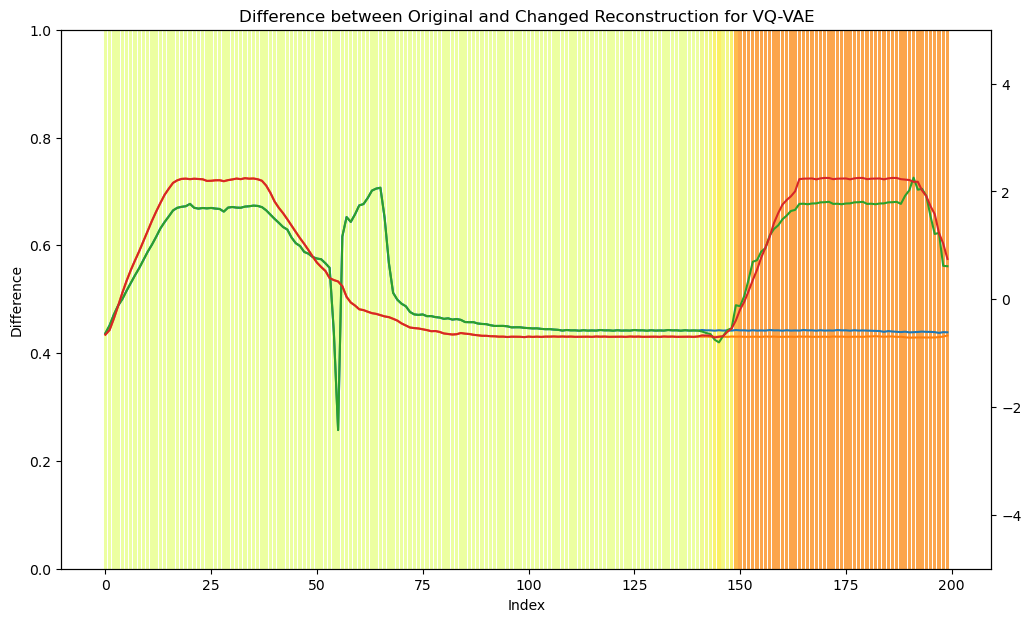

Q-Embeddings Indices:  [ 47  49 207 207 207 149 251  87  88 116 151 214 214 133 133 133 133 133
 133 133 133 133 133 133 133  98]


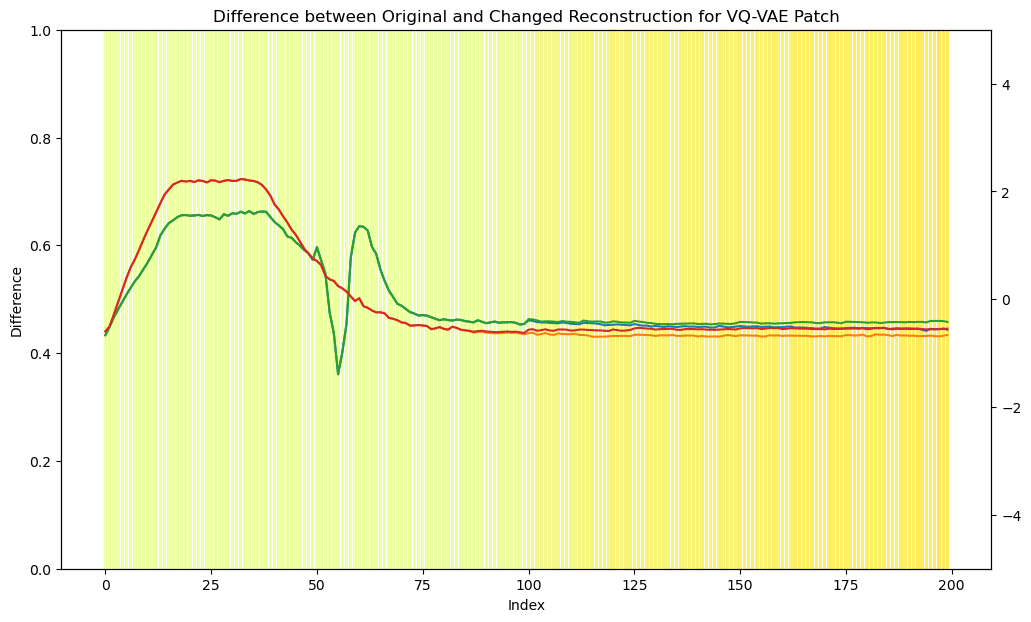

Q-Embeddings Indices:  [172 197 223  80  80  80  80  80  32 197 177  80 217 217 217 217]


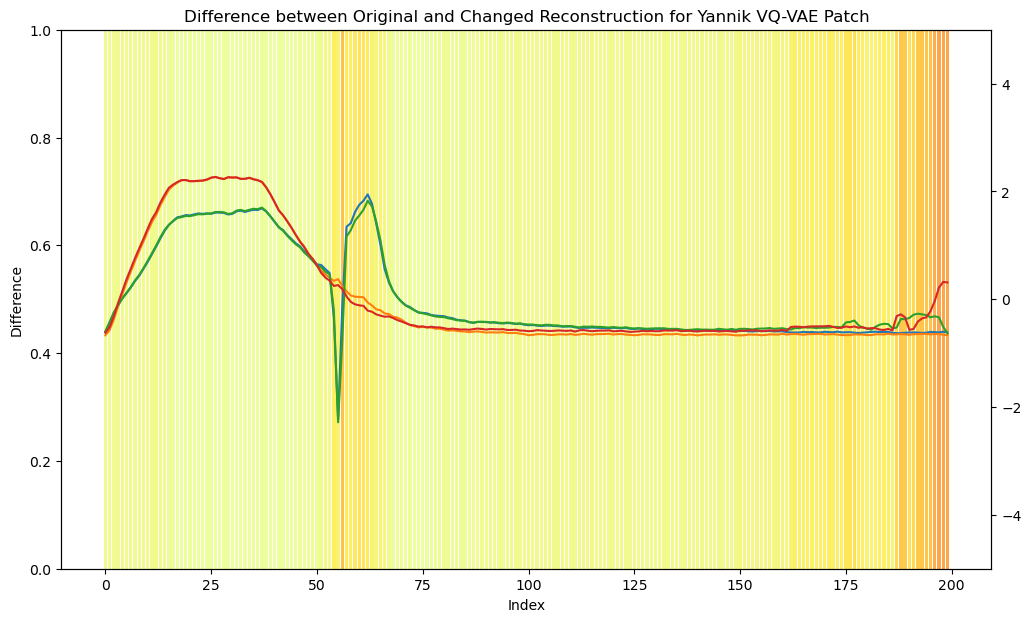

Q-Embeddings Indices:  [107 107 116 162 216  88  88  88 135 135 162 216 183 183 183 183]


In [168]:
def plot_reconstruction_difference(reconstructed_original, reconstructed_changed, original, label, plot_original=False):
    difference = torch.sum(torch.abs(reconstructed_original - reconstructed_changed), dim=1)
    colormap = plt.colormaps['Wistia']
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 7)
    ax2 = ax.twinx()
    bars = ax.bar(np.arange(len(reconstructed_original)), [1] * len(reconstructed_original), color=colormap(difference), alpha=0.7)
    ax.set_ylim(0, 1)
    ax2.set_ylim(-5, 5)
    ax.set_xlabel('Index')
    ax.set_ylabel('Difference')
    ax2.plot(reconstructed_original)
    ax2.plot(reconstructed_changed)
    # label fig
    ax.set_title(f'Difference between Original and Changed Reconstruction for {label}')
    if plot_original: ax2.plot(original)
    plt.show()
    return difference

def alter_q_data(q_data, original_data, alter_range, alter_embedding, model, label, plot_original=False):
    changed_q_data = q_data.clone().detach()
    codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)
    # replacing four embeddings with least common Codebook Entry number 165
    for i in alter_range:
        changed_q_data[i] = codebook[alter_embedding] 
    reconstructed_original, _= send_through_decoder(model=model, q_data=q_data.unsqueeze(0), original_data = original_data, label=label)
    reconstructed_changed, _= send_through_decoder(model=model, q_data=changed_q_data.unsqueeze(0), original_data = original_data, label=label)
    difference = plot_reconstruction_difference(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=original_data, label=label, plot_original=plot_original)

test_dpt = 3
original_data = torch.tensor(train_data[test_dpt])

alter_q_data(q_data=complete_q_tensor[test_dpt], original_data=original_data, alter_range = range(20, 26), alter_embedding = 207, model=model, label="VQ-VAE")
print("Q-Embeddings Indices: ", complete_q_indices[test_dpt])
alter_q_data(q_data=complete_q_tensor_patch[test_dpt], original_data=original_data, alter_range = range(12, 16), alter_embedding = 80, model=mein_model, label="VQ-VAE Patch")
print("Q-Embeddings Indices: ", complete_q_indices_patch[test_dpt])
alter_q_data(q_data=complete_q_tensor_yannik_patch[test_dpt], original_data=original_data, alter_range = range(12, 16), alter_embedding = 116, model=y_model, label="Yannik VQ-VAE Patch")
print("Q-Embeddings Indices: ", complete_q_indices_yannik_patch[test_dpt])

In [114]:
complete_q_indices_patch[test_datapoint]

array([225, 197, 217, 252, 106, 217, 217, 217,  32, 197, 177,  80, 217,
       217, 217, 217])

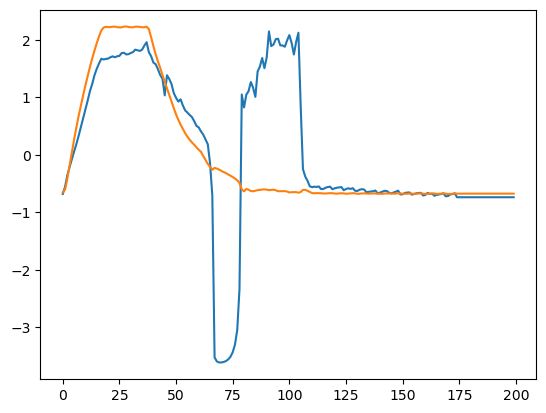

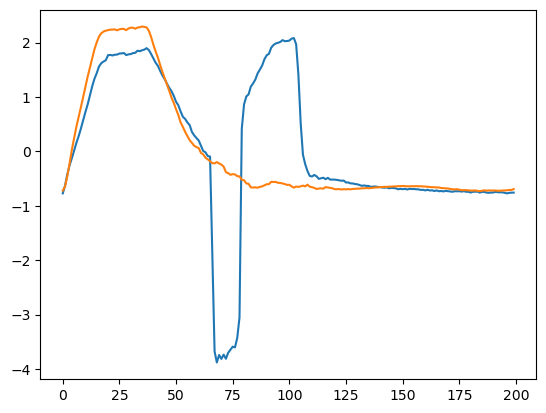

In [125]:
# for i in range(10):
i=2
reconstructed_original= send_through_decoder(complete_q_tensor[i], model=model)[0]
plt.plot(train_data[i])
plt.show()
plt.plot(reconstructed_original)
plt.show()

/tmp/ipykernel_3109641/3505150949.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  changed_tensor = torch.tensor(complete_q_tensor[2])


torch.Size([26, 32])


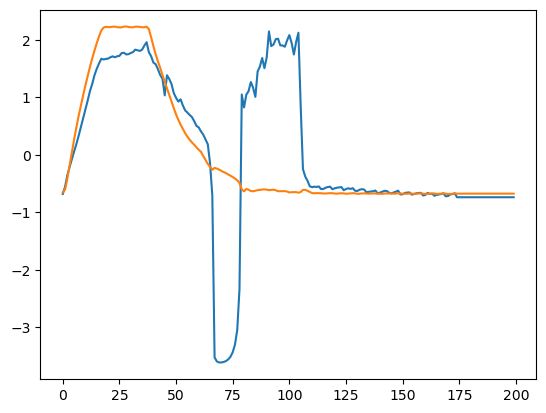

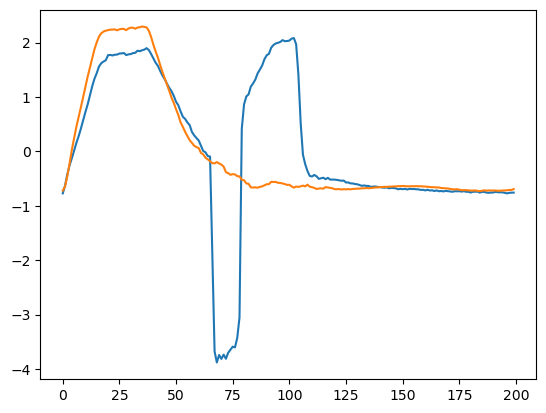

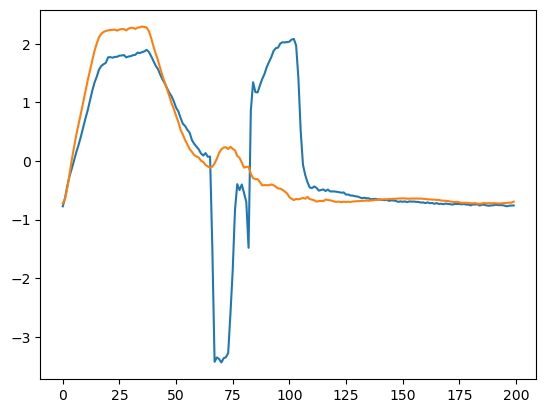

In [132]:
changed_tensor = torch.tensor(complete_q_tensor[2])
# replacing four embeddings with least common Codebook Entry number 230
for i in range(10,12):
    changed_tensor[i] = codebook[165] 

print(changed_tensor.shape)
plt.plot(train_data[2])
plt.show()
plt.plot(send_through_decoder(complete_q_tensor[2], model=model)[0])
plt.show()
plt.plot(send_through_decoder(changed_tensor, model=model)[0])
plt.show()

# Funktion zur Bestimmung der Auswirkung von Änderungen der Embeddings